In [3]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

_ColormakerRegistry()

In [4]:
def plot(vacf_sim, vacf_target, g_sim, rdf_target):

    t_range = np.array([0] + vacf_obs.t_window) * 0.01

    plt.plot(t_range, vacf_sim.detach().cpu().numpy(), label='simulation')
    plt.plot(t_range, vacf_target.detach().cpu().numpy(), label='target' )

    plt.legend()
    plt.show()

    bins = np.linspace(0.5, 2.5, obs.nbins)

    plt.plot(bins, g_sim.detach().cpu().numpy() , label='simulation')
    plt.plot(bins, rdf_target[1].detach().cpu().numpy() , label='target')

    plt.show()

## Set up systems

In [38]:
from ase.lattice.cubic import FaceCenteredCubic
from ase import units

from torchmd.interface import GNNPotentials,PairPotentials, Stack
from torchmd.system import System
from torchmd.potentials import ExcludedVolume, LennardJones
from nff.train import get_model

size = 3
L = 1.679
device = 2

atoms = FaceCenteredCubic(directions=[[1, 0, 0], 
                                    [0, 1, 0], 
                                    [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant=L,
                          pbc=True)

from torchmd.system import System
system = System(atoms, device=device)
system.set_temperature(1.0 /units.kB)

## Set up equations of motions

In [60]:

# parameter for SchNet 
params = {
    'n_atom_basis': 64,
    'n_filters': 64,
    'n_gaussians': 16,
    'n_convolutions': 2,
    'cutoff': 1.25,
    'trainable_gauss': False
}


# Define prior potential 
lj_params = {'epsilon': 0.9, 
             'sigma': 1.05}

from torchmd.potentials import ExcludedVolume
from nff.train import get_model


pair = PairPotentials(system, LennardJones, lj_params,
                cutoff=2.5,
                ).to(device)

model = get_model(params)
GNN = GNNPotentials(system, model,  cutoff=1.25)
model = Stack({
                'gnn': GNN, 
                'pair': pair
})


from torchmd.md import NoseHooverChain 
diffeq =NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=1.0,
            num_chains=5, 
            adjoint=False).to(device)

The input temperature is 11604.522060401008 K, it seems too high.


## Set up observation function

In [61]:
from torchmd.observable import rdf, vacf

# Set up observable 
obs = rdf(system, nbins=100, r_range=(0.5, 2.5))
vacf_obs = vacf(system, t_range=50) 

In [62]:
# Get Target observable 

In [63]:
nbins = 100

vacf_target = np.loadtxt('../data/LJ_data/vacf_rho0.884_T1.0_dt0.01.csv', delimiter=',')
rdf_target = np.loadtxt('../data/LJ_data/rdf_rho0.884_T1.0_dt0.01.csv', delimiter=',')

vacf_target = torch.Tensor(vacf_target).to(device)
rdf_target = torch.Tensor(rdf_target).to(device)

In [64]:
def JS_rdf(g_obs, g):
    e0 = 1e-4
    g_m = 0.5 * (g_obs + g)
    loss_js =  ( -(g_obs + e0 ) * (torch.log(g_m + e0 ) - torch.log(g_obs +  e0)) ).mean()
    loss_js += ( -(g + e0 ) * (torch.log(g_m + e0 ) - torch.log(g + e0) ) ).mean()

    return loss_js

In [65]:
from torchmd.md import Simulations

optimizer = torch.optim.Adam(list(GNN.parameters()), lr=1e-5)

# Set up simulations 
sim = Simulations(system, diffeq)

## Simulate

0.045190442353487015 1.7912694215774536


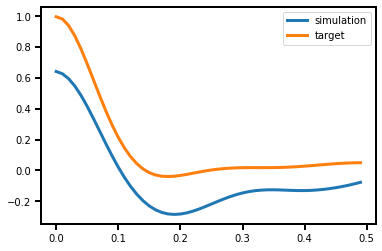

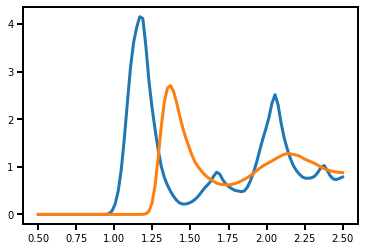

0.033838916569948196 1.5499154329299927
0.03729593753814697 1.4134758710861206
0.03880035877227783 1.3615784645080566
0.03322078660130501 1.331616997718811
0.03965860605239868 1.4136154651641846


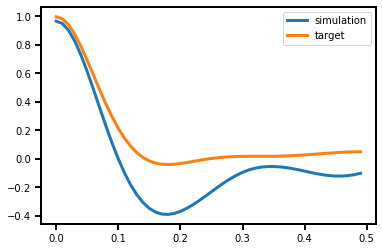

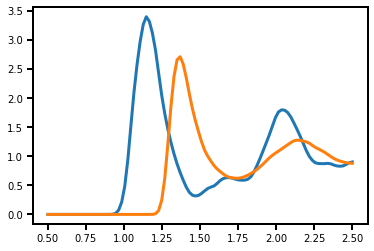

0.03838580101728439 1.4793527126312256
0.04038179665803909 1.429250717163086
0.027876071631908417 1.3064122200012207
0.03642822057008743 1.2977101802825928
0.03158552944660187 1.4074640274047852


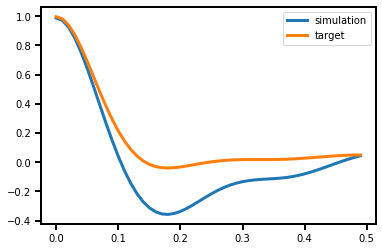

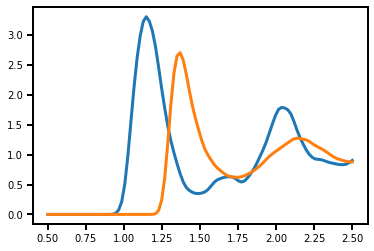

0.034502528607845306 1.4298208951950073
0.037633173167705536 1.3855828046798706
0.0383891798555851 1.3982807397842407
0.04004964232444763 1.4051337242126465
0.03697733208537102 1.4482766389846802


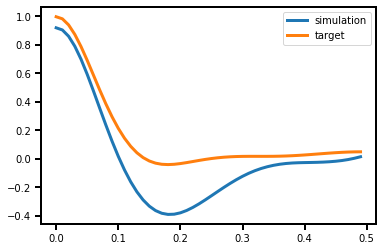

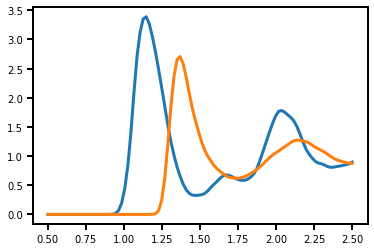

0.03438455983996391 1.5800836086273193
0.03164214640855789 1.4585692882537842
0.03816912695765495 1.4025588035583496
0.041936200112104416 1.4105241298675537
0.033451974391937256 1.460074543952942


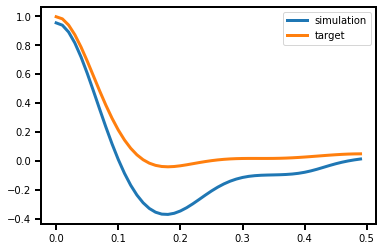

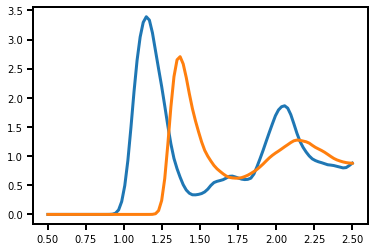

0.03085269406437874 1.46812105178833
0.0347696915268898 1.4091570377349854
0.03475109860301018 1.335241436958313
0.0320877768099308 1.337274193763733
0.040156930685043335 1.4761416912078857


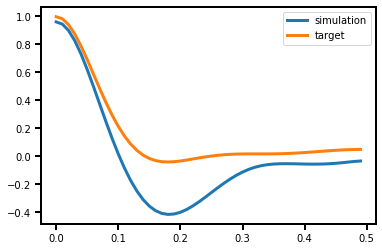

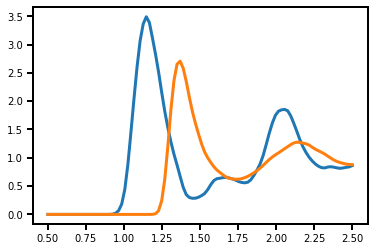

0.032485753297805786 1.390267252922058
0.040065545588731766 1.429260015487671
0.045976534485816956 1.4047805070877075
0.03525777906179428 1.4193791151046753
0.030363118276000023 1.5033133029937744


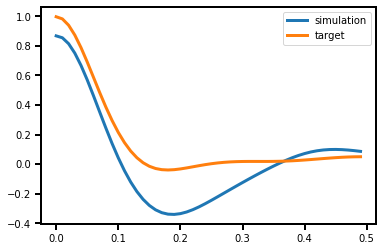

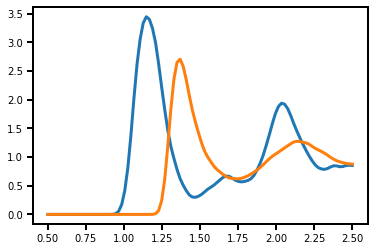

0.03388157859444618 1.512196660041809
0.04420056194067001 1.4587973356246948
0.040151581168174744 1.4163713455200195
0.03357765078544617 1.3977067470550537
0.03721506893634796 1.424832820892334


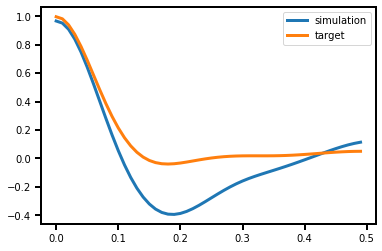

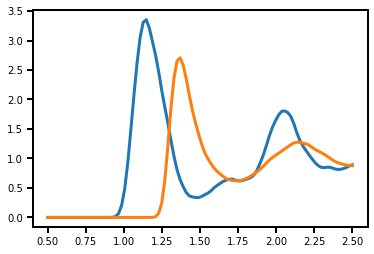

0.03228328004479408 1.3605895042419434
0.03392195329070091 1.3623441457748413
0.03855200856924057 1.3323092460632324
0.04145532101392746 1.3982728719711304
0.04139808192849159 1.4392578601837158


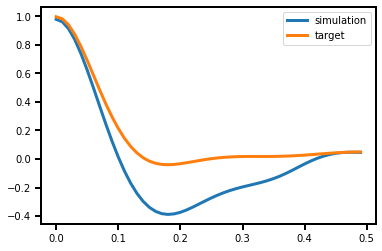

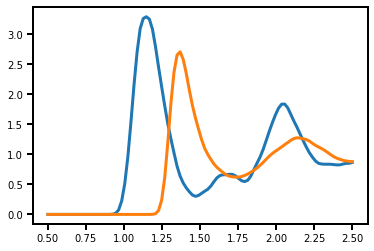

0.044746655970811844 1.4412682056427002
0.04182866960763931 1.418616771697998
0.04214833676815033 1.3797743320465088
0.045505914837121964 1.3850561380386353
0.030521240085363388 1.3742228746414185


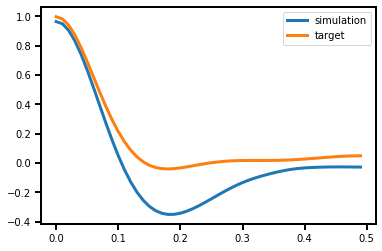

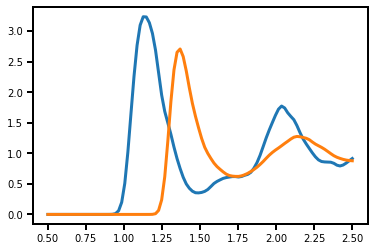

0.035599589347839355 1.4200561046600342
0.03009444661438465 1.3905572891235352
0.033117931336164474 1.3419097661972046
0.04550491273403168 1.3735054731369019


In [66]:
# %%timeit

for i in range(50):

    # Simulate 
    v_t, q_t, pv_t = sim.simulate(steps=50, frequency=50, dt=0.01)

    # compute observable 
    _, _, g_sim = obs(q_t)

    vacf_sim = vacf_obs(v_t)

    loss_vacf = (vacf_sim - vacf_target).pow(2).mean()
    loss_rdf = (g_sim - rdf_target[1]).pow(2).mean() + JS_rdf(g_sim, rdf_target[1])

    loss = loss_rdf + loss_vacf
    
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    print(loss_vacf.item(), loss_rdf.item())
    
    if i % 5 ==0 :
        plot(vacf_sim, vacf_target, g_sim, rdf_target)
    

In [ ]:
# from utils import display_traj

# display_traj(system, diffeq.traj)

In [33]:
g_sim.shape

torch.Size([100])

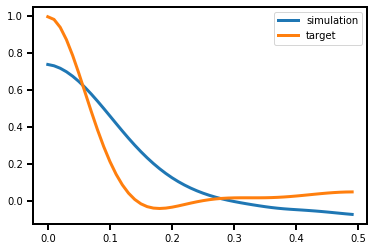

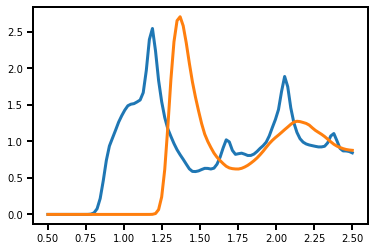

In [10]:
plot()